# Time Series Forecast: ARIMA vs LSTM 
https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b

## Before running this script, Install pmdarima and fbprophet

pip install pmdarima


In [1]:
### 0 - Setup
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For Arima
import pmdarima
import statsmodels.tsa.api as smt
## For Lstm
from tensorflow.keras import models, layers, preprocessing as kprocessing


###### Import pckgs 

In [2]:
import warnings
warnings.filterwarnings("ignore")

from ts_utils import *    #this is ts_utils.py in the same folder, include lots of time series models and plot utilites



###### Import data

In [32]:
dtf = pd.read_csv('data_sales.csv')
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [33]:
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')


In [5]:
#store daily sales time series as a pandas series 
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()


<class 'pandas.core.series.Series'>


In [6]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

### 1 - TimeSeries Analysis

###### Check for:
- Trend 
- Level
- Outliers
- Stationarity
- Seasonality (define s)

###### Target Variable

In [7]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))

#ewm provides exponential weighted (EW) smoothing function
# y0=x0, y(t)=(1-a)y(t-1)+ a*x(t)
#Specify decay in terms of span, a=2/(span+1),
w = 30  #window length
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 1034 | mean: 3528  | std: 1585
moving --> len: 30  | mean: 2305  | std: 773


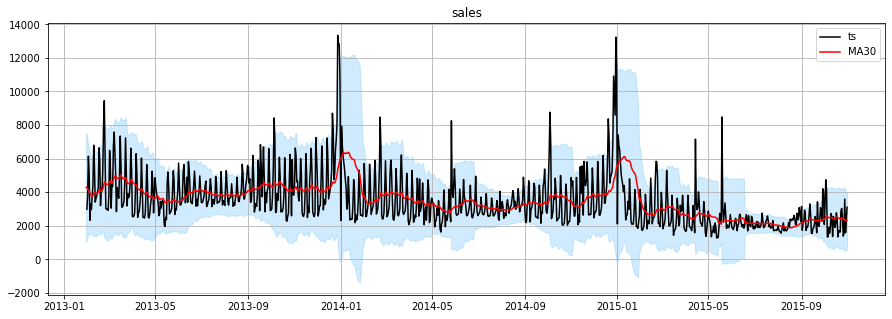

In [8]:
#using utils_ts.py functions to plot 30 day moving average, 30day moving average + - 1.96* 30day std as bounds
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

###### Trend

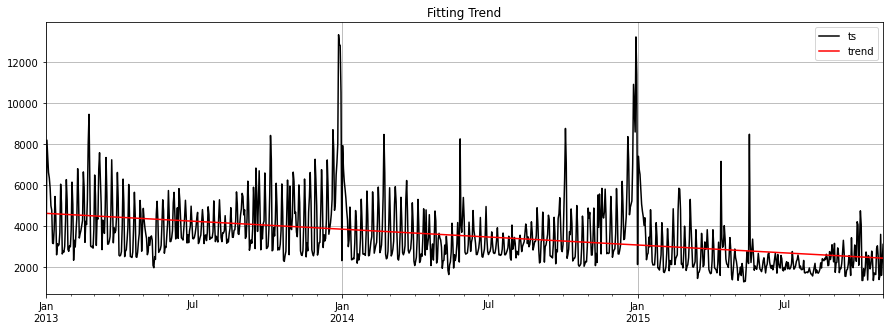

In [9]:
trend, line = fit_trend(ts, degree=1, plot=True, figsize=(15,5))

In [10]:
# -> There is a slight trend and it's linear ("additive")
print("constant:", round(line[-1],2), "| slope:", round(line[0],2))

constant: 4622.02 | slope: -2.12


###### Level, resistence and support, useful for stock price prediction

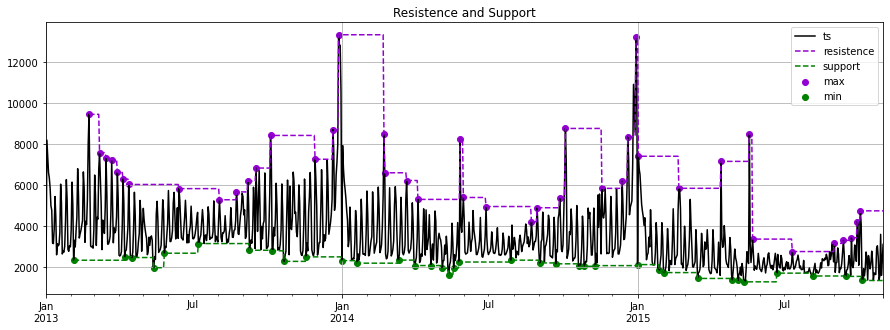

In [11]:
res_sup = resistence_support(ts, window=30, trend=False, plot=True, figsize=(15,5))

###### Outliers

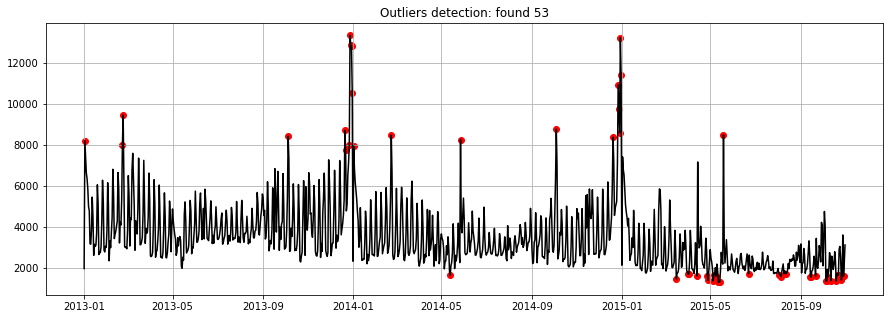

In [12]:
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

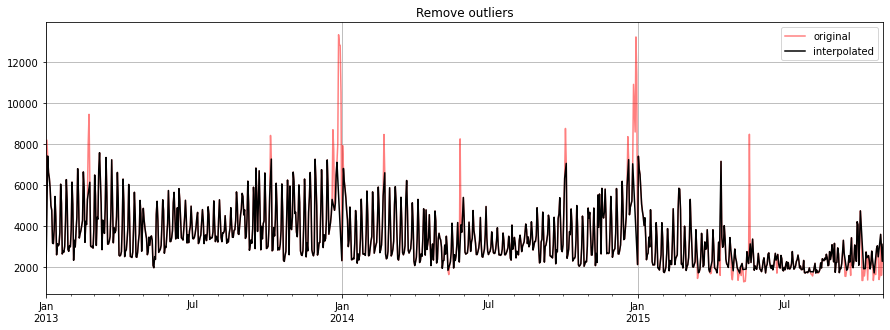

In [13]:
ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

In [14]:
# -> I will keep the outliers. the peaks are likely due to seasonality and should not be smoothed

###### Stationarity

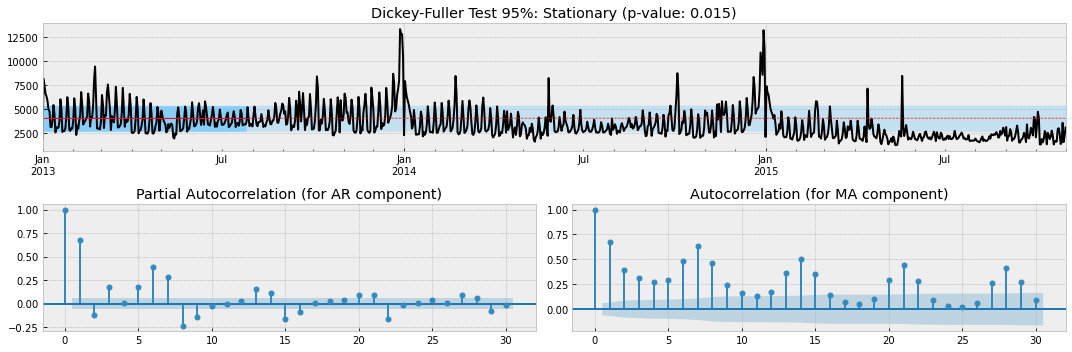

In [15]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

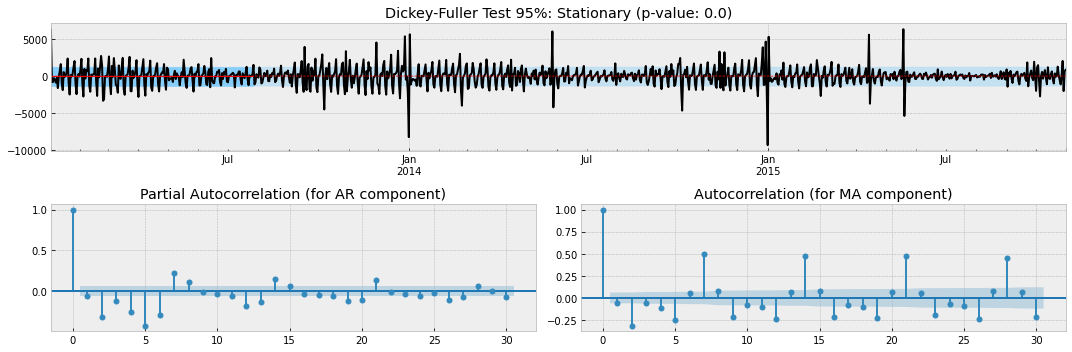

In [16]:
# I'm not sure: the test says it's stationary but it doesn't look like, let's try with differentiating the ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

In [17]:
# CLearly there is stationarity every 2 days (negative: at the beginning of the week less sales) 
# and 7 days (positive: more sales on the weekend)
# -> I will use the raw ts.

###### Seasonality, does data show weekly seasonality (s=7), ie data depends on day of week?

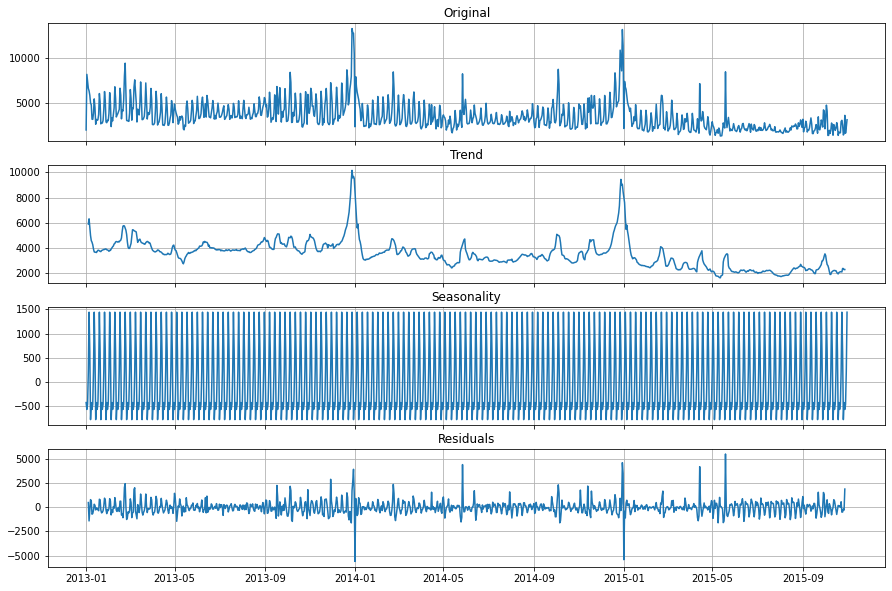

In [18]:
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

In [19]:
# -> Using weekly seasonality there are smaller residuals
s = 7
#potentially, we can aggregate to monthly to a monthly forecast with seasonality of 12 months, Jan has higher sales
#then aggregate to daily to do a daily forecast, weekend has higher sales
#apply daily factors from daily forecast to monthly forecast to get final daily forecast

### 2 - Preprocessing

###### Differenciating

In [20]:
# I will use the raw ts

###### Partitioning

--- splitting at index:  881 | 2015-06-01 00:00:00 | test size: 0.15  ---


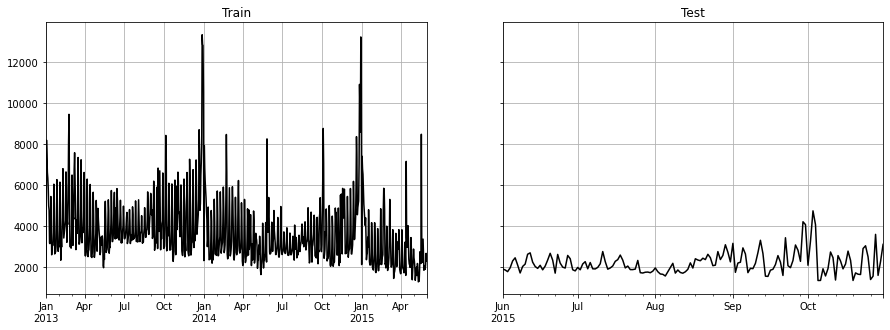

train: 881 obs  |  test: 153 obs


In [21]:
#split history into train and test, data before 2015-06-01 for training, after for testing
ts_train, ts_test = split_train_test(ts, exog=None, test="2015-06-01", plot=True, figsize=(15,5))
print("train:", len(ts_train), "obs  |  test:", len(ts_test), "obs")

### 3 - Exponential Smoothing model

###### Exponential Smoothing

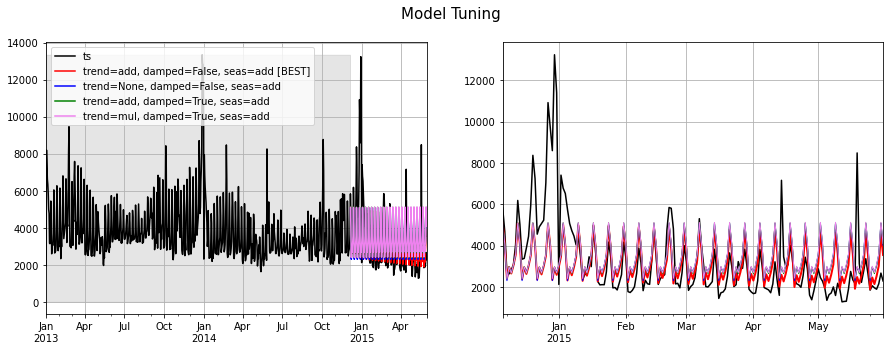

,combo,score,model
0,"trend=add, damped=False, seas=add",1096.079899,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,"trend=None, damped=False, seas=add",1272.542117,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,"trend=add, damped=True, seas=add",1280.269860,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,"trend=mul, damped=True, seas=add",1297.099636,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,"trend=mul, damped=False, seas=add",1402.910927,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [22]:
# Tuning, s=7 means 7 day seasonality
res = tune_expsmooth_model(ts_train,  s=7, val_size=0.2, scoring=metrics.mean_absolute_error, top=4, figsize=(15,5))
res.head()

Seasonal parameters: multiplicative Seasonality every 7 observations
--- computing confidence interval ---


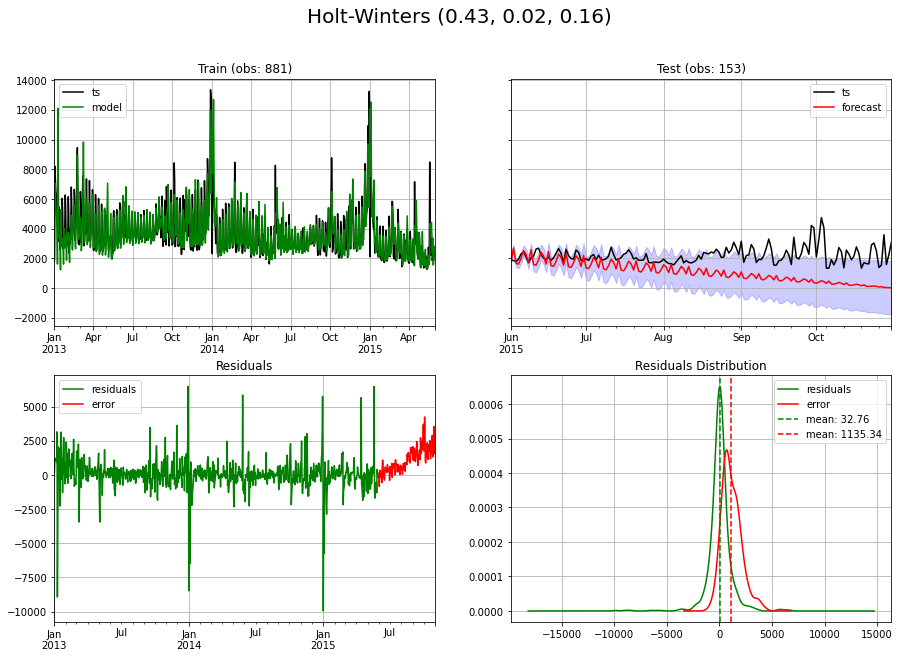

Training --> Residuals mean: 33.0  | std: 1117.0
Test --> Error mean: 1135.0  | std: 910.0  | mae: 1174.0  | mape: 51.0 %  | mse: 2111341.0  | rmse: 1453.0


In [23]:
# Train/Test, residule is forecast/actual difference during training period, error is the difference during testing period
dtf, model = fit_expsmooth(ts_train, ts_test, trend="additive", damped=False, seasonal="multiplicative", s=s ,
                           factors=(None,None,None), conf=0.10, figsize=(15,10))

In [24]:
#-> On forecasting, the average error of prediction in 388 unit of sales (16% of the predicted value).

--- generating index date --> freq: D | start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


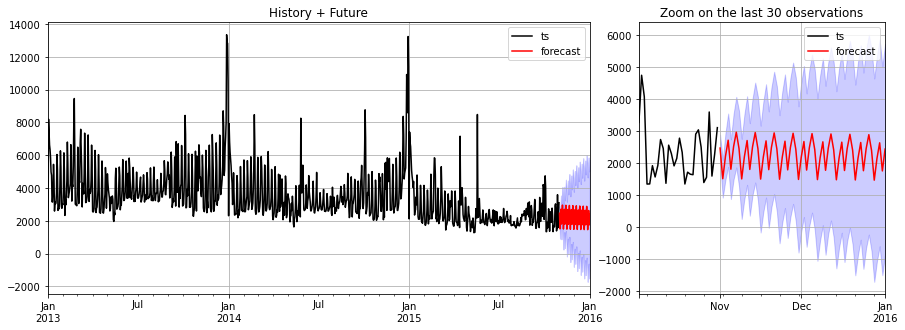

In [25]:
# Forecast unknown
model = smt.ExponentialSmoothing(ts, trend="additive", damped=False, 
                                 seasonal="multiplicative", seasonal_periods=s).fit(0.64)

future = forecast_autoregressive(ts, model, end="2016-01-01", conf=0.30, zoom=30, figsize=(15,5))

In [26]:
#the forecast is stored in a panda data frame
future.tail()

,ts,model,residuals,lower,forecast,upper
2015-12-28,NaN,NaN,NaN,-1718.515766,1461.496540,4641.508846
2015-12-29,NaN,NaN,NaN,-1066.666825,2140.642224,5347.951274
2015-12-30,NaN,NaN,NaN,-604.849931,2629.525497,5863.900926
2015-12-31,NaN,NaN,NaN,-1511.488593,1749.728585,5010.945764
2016-01-01,NaN,NaN,NaN,-853.363914,2434.475887,5722.315688


In [27]:
#-> Exp Smooth models predict that the series will keep the downtrend and there won't be any peaks next January.

## 4.  ARIMA model

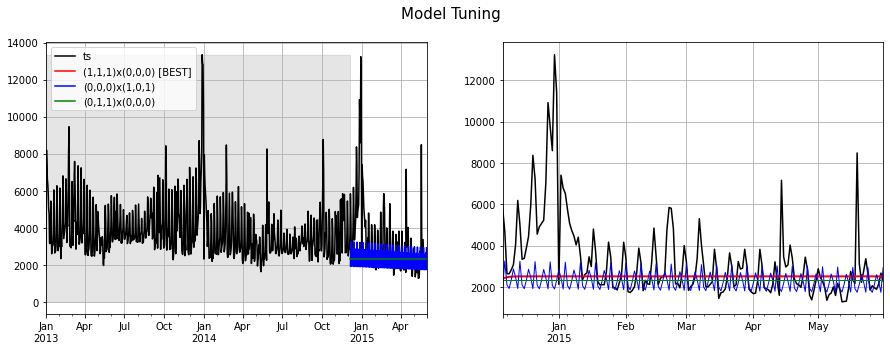

,combo,score,model
0,"(1,1,1)x(0,0,0)",1267.729998,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(0,0,0)x(1,0,1)",1284.688509,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(0,1,1)x(0,0,0)",1288.717213,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(1,1,0)x(0,0,0)",1293.258417,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(0,1,0)x(0,0,0)",1296.548023,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [81]:
# Tuning (this takes a while)
res = tune_arima_model(ts_train, s=s, val_size=0.2, max_order=(1,1,1), seasonal_order=(1,0,1),
                        scoring=metrics.mean_absolute_error, top=3, figsize=(15,5))
res.head()

In [ ]:
# Tuning (this takes a while)
find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

Trend parameters: d=1
Seasonal parameters: Seasonality every 7 observations
Exog parameters: Not given


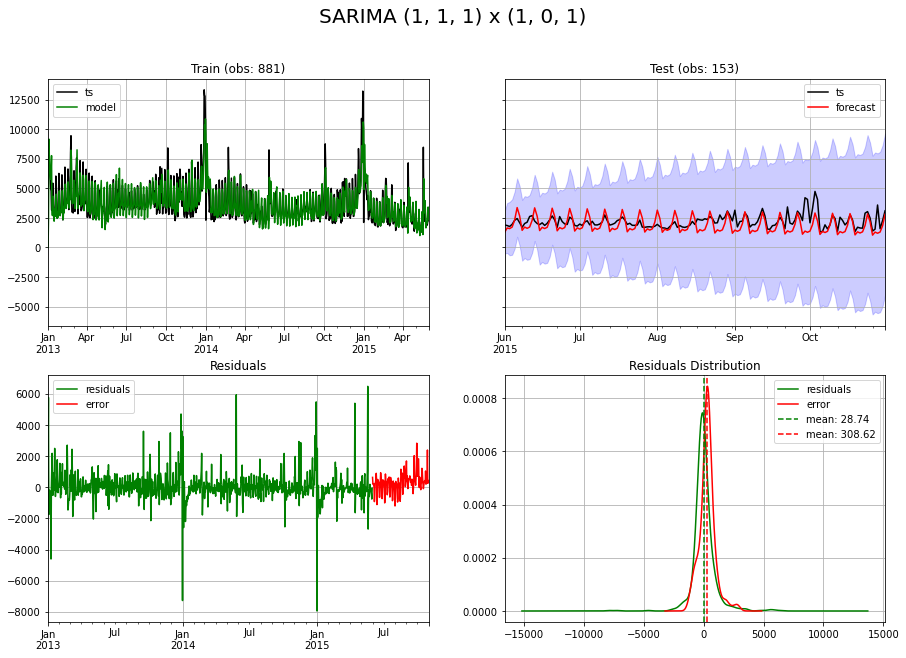

Training --> Residuals mean: 29.0  | std: 951.0
Test --> Error mean: 309.0  | std: 654.0  | mae: 540.0  | mape: 23.0 %  | mse: 520739.0  | rmse: 722.0


In [34]:
# Train/Test, note errors are smaller than exponential smoothing
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1), s=s, conf=0.95, figsize=(15,10))

In [35]:
#-> On forecasting, the average error of prediction in 394 unit of sales (17% of the predicted value).

--- generating index date --> freq: D | start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


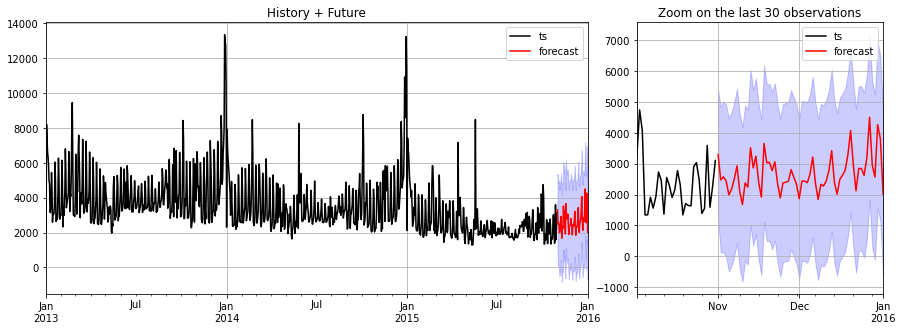

In [48]:
# Forecast unknown
model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None).fit()

future = forecast_autoregressive(ts, model, end="2016-01-01", conf=0.95, zoom=30, figsize=(15,5))

In [47]:
future.tail()

,ts,model,residuals,lower,forecast,upper
2015-12-28,NaN,NaN,NaN,3955.383522,7252.919465,10550.455407
2015-12-29,NaN,NaN,NaN,4067.146464,7392.987955,10718.829446
2015-12-30,NaN,NaN,NaN,5840.027046,9193.935208,12547.843369
2015-12-31,NaN,NaN,NaN,3661.299387,7043.041288,10424.783190
2016-01-01,NaN,NaN,NaN,-2098.537608,1310.810808,4720.159224


In [ ]:
#-> Autoregressive models predict that the series will keep the downtrend and there won't be any peaks next January.

## 5 - LSTM Model (Long short term memory Neural Network)

###### Train / Evaluate

In [28]:
# I will try to expand the memory to 1y, losing 365 days of training. This takes a while.
s = 365
n_features = 1


In [29]:
# Number of features is 1, num_units in TensorFlow is the number of hidden states,
model = models.Sequential()
model.add( layers.LSTM(input_shape=(s,n_features), units=50, activation='relu', return_sequences=True) )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 365, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Seasonality: using the last 365 observations to predict the next 1
--- X: (516, 365, 1) | y: (516,) ---
--- computing confidence interval ---


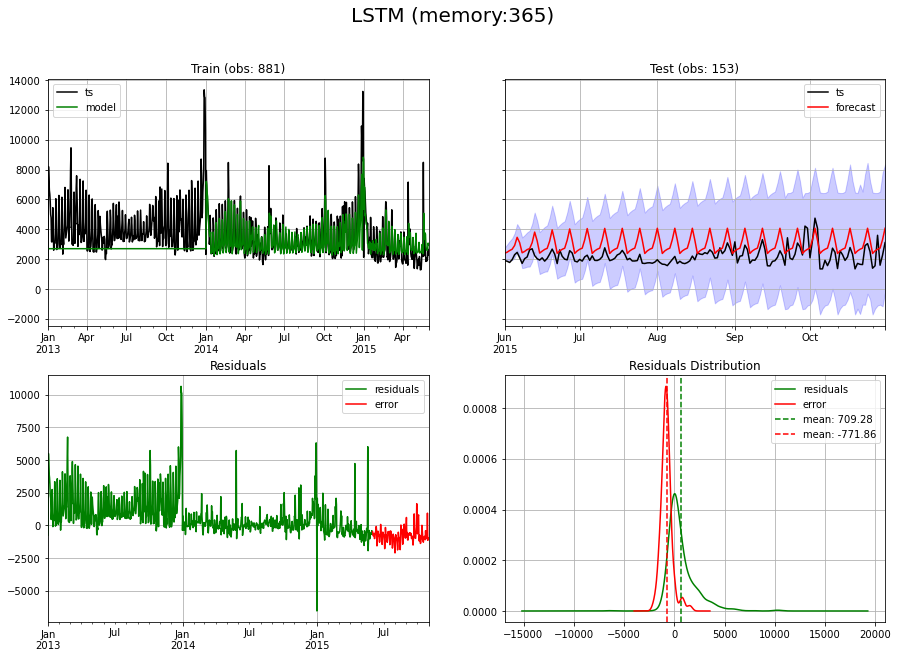

Training --> Residuals mean: 709.0  | std: 1451.0
Test --> Error mean: -772.0  | std: 566.0  | mae: 866.0  | mape: 42.0 %  | mse: 914445.0  | rmse: 956.0


In [30]:
dtf, model = fit_lstm(ts_train, ts_test, model, exog=None, s=s, epochs=100, conf=0.20, figsize=(15,10))

In [31]:
#-> On forecasting, the average error of prediction in 1077 unit of sales (51% of the predicted value).

###### Forecast unknown 

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


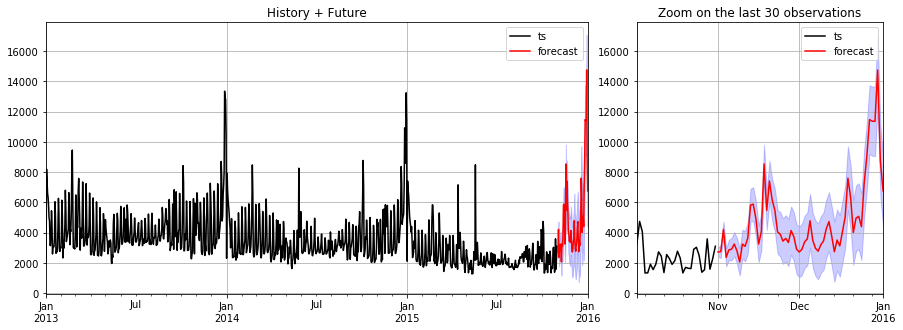

In [130]:
future = forecast_lstm(ts, model, conf=0.20, end="2016-01-01", zoom=30, figsize=(15,5))

In [38]:
#-> Lstm with 1y of memory predicts that the series will replicate yearly seasonality, with peaks in January.

### 6 - Facebook Prophet Model

###### Train / Evaluate

In [18]:
# Create dataframe with columns 'ds' (dates), 'y' (values), 'cap' (capacity if growth="logistic"), 
# other additional regressor
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

,ds,y
876,2015-05-27,1953.0
877,2015-05-28,1885.0
878,2015-05-29,2146.0
879,2015-05-30,2665.0
880,2015-05-31,2283.0


In [19]:
# Create Holidays dataFrame with columns 'ds' (dates) and 'holiday' (string ex 'xmas')
dtf_holidays = None

In [20]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

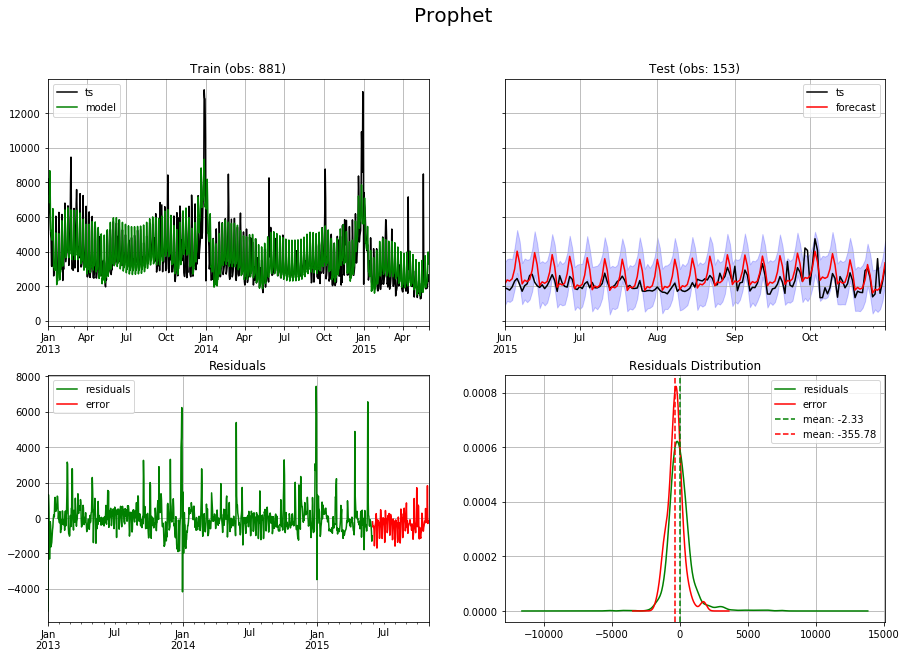

Training --> Residuals mean: -2.0  | std: 963.0
Test --> Error mean: -356.0  | std: 581.0  | mae: 534.0  | mape: 25.0 %  | mse: 461781.0  | rmse: 680.0


In [21]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, figsize=(15,10))

In [22]:
#-> On forecasting, the average error of prediction in 534 unit of sales (25% of the predicted value).

###### Forecast unknown 

In [23]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

,ds,y
1029,2015-10-27,1551.0
1030,2015-10-28,3593.0
1031,2015-10-29,1589.0
1032,2015-10-30,2274.0
1033,2015-10-31,3104.0


In [24]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


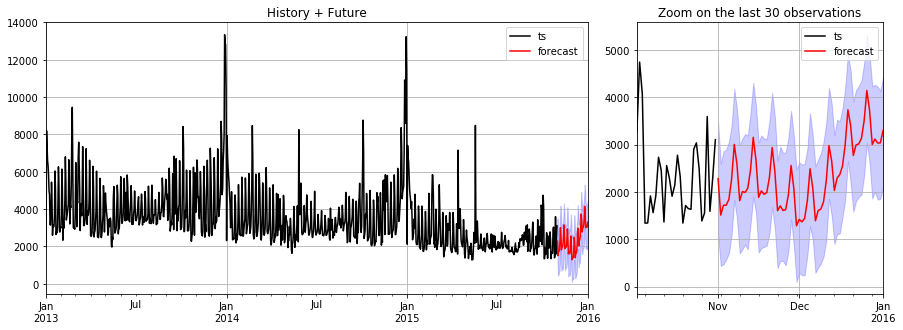

In [25]:
future = forecast_prophet(dtf, model, end="2016-01-01", zoom=30, figsize=(15,5))

In [46]:
#-> Prophet predicts that the series will keep the downtrend but includes yearly seasonality, 
#   with samller peaks in January.

### 7 - Custom Model
<pre>
From scratch model with Trend + Seasonality (independent from s) + Level + Resistence/Support and Cap/Floor adjustemetns.
:parameter
    :param ts: pandas series with datetime index 
    :param trend: bool - if True fits a trend line
    :param seasonality_types: None or list - ["dow", "dom", "doy", "woy", "moy"], if empty it applies all
    :param level_window: num - used for rolling smoothing of the level
    :param sup_res_windows: tuple - ex. (180, 60) --> if the forecast mean below support or above resistence, the level is shifted
    :param floor_cap: tuple of bool - ex. (True,True) --> values over cap are replaced with cap and values below floor are replaced with floor
:return
    series with fitted_values, series with preds
</pre>

###### Train / Evaluate

--- generating index date --> freq: D | start: 2014-12-06 00:00:00 | end: 2015-05-30 00:00:00 | len: 176 ---


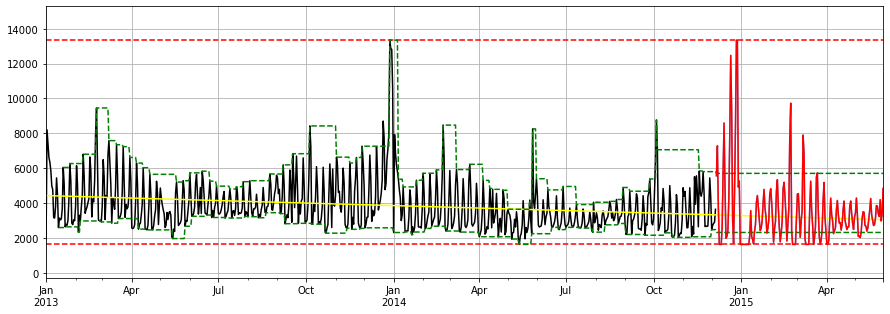

In [39]:
# Tuning
tune = custom_model(ts_train.head(int(0.8*len(ts_train))), pred_ahead=int(0.2*len(ts_train)), 
                    trend=True, seasonality_types=["dow","dom","doy","woy","moy"], 
                    level_window=7, sup_res_windows=(365,365), floor_cap=(True,True), 
                    plot=True, figsize=(15,5))

In [40]:
trend = True
seasonality_types = ["dow","dom","doy","woy","moy"]
level_window = 7
sup_res_windows = (365,365)
floor_cap = (True,True)

--- generating index date --> freq: D | start: 2015-06-01 00:00:00 | end: 2015-10-31 00:00:00 | len: 153 ---
--- computing confidence interval ---


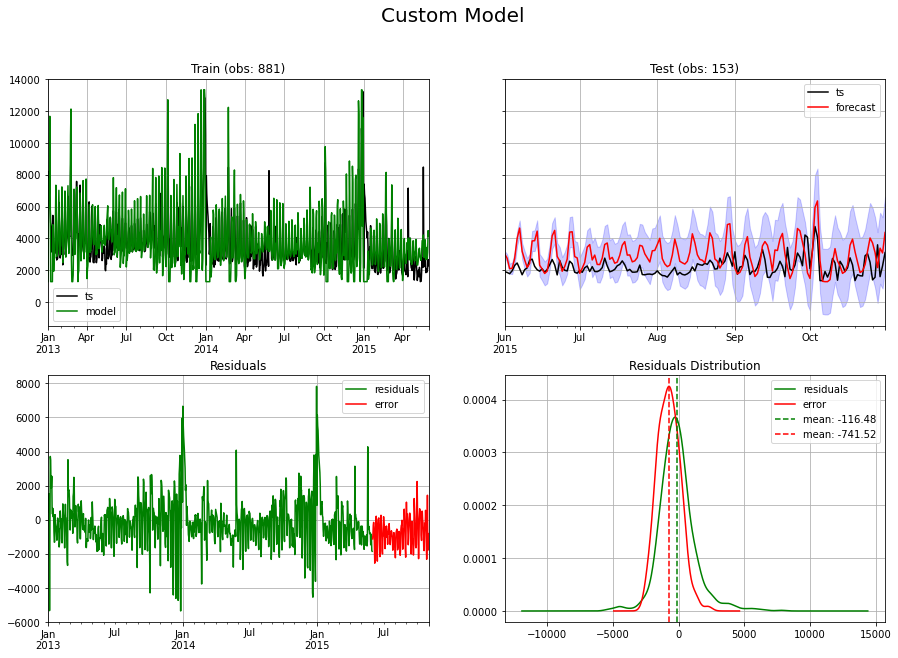

Training --> Residuals mean: -116.0  | std: 1398.0
Test --> Error mean: -742.0  | std: 851.0  | mae: 930.0  | mape: 44.0 %  | mse: 1269838.0  | rmse: 1127.0


In [41]:
dtf = fit_custom_model(ts_train, ts_test, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                       conf=0.1, figsize=(15,10))

###### Forecast unknown 

--- generating index date --> freq: D | start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- generating index date --> freq: D | start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


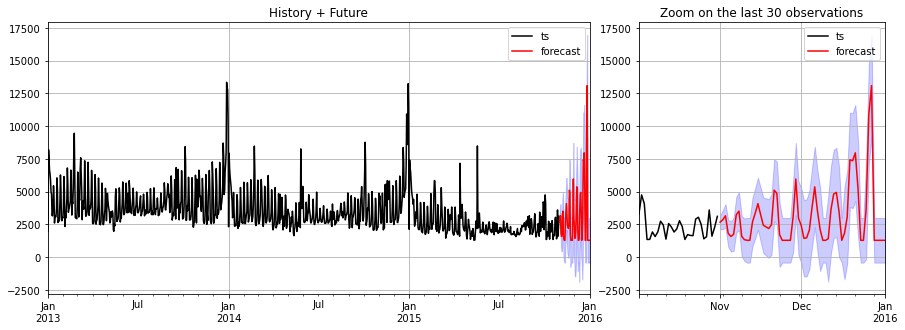

In [42]:
future = forecast_custom_model(ts, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                               conf=0.3, end="2016-01-01", zoom=30, figsize=(15,5))